In [1]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
img = cv2.imread('/home/wroscoe/code/ceres/notebooks/field.png')

In [3]:
def norm_image(img):
    return (img - img.mean() / np.std(img))/255.0

norm_img = norm_image(img)

In [143]:
import random

def get_row(source_img, size=80, max_offset=20):
    """
    Given an source image return a two partial images and 
    their x,y offset from one another.
    """
    
    source_x = source_img.shape[1]
    source_y = source_img.shape[0]
    
    x_offset = random.randint(-max_offset, max_offset)
    y_offset = random.randint(-max_offset, max_offset)
    
    min_x = max(0, 0-x_offset)
    min_y = max(0, 0-y_offset)
    max_x = min(source_x-size, source_x-size-x_offset)
    max_y = min(source_y-size, source_y-size-y_offset)
    
    img_x = random.randint(min_x, max_x)
    img_y = random.randint(min_y, max_y)
    
    #print('min_x: {}  min_y:{}, max_x:{}, max_y:{}'.format(min_x, min_y, max_x, max_y))
    #print('img_x: {}  img_y:{}'.format(img_x, img_y))
    #print('x_offset: {}  y_offset:{}'.format(x_offset, y_offset))
    
    img = source_img[img_y:img_y+size, img_x:img_x+size]
    
    img_offset = source_img[img_y+y_offset:img_y+size+y_offset,
                            img_x+x_offset:img_x+size+x_offset]
    
    
    x_offset_norm = x_offset/size
    y_offset_norm = y_offset/size
    
    
    return img, img_offset, x_offset_norm, y_offset_norm

In [144]:

#helper function to show several images
def show_imgs(img_arr, cmap=None):
    
    fig, ax = plt.subplots(1, img_arr.shape[0], figsize=(15, 6),
                             subplot_kw={'adjustable': 'box-forced'})

    axoff = np.vectorize(lambda ax:ax.axis('off'))
    axoff(ax)

    for i, img in enumerate(img_arr):
        ax[i].imshow(img, cmap=cmap)

In [145]:
for i in range(1000):
    img, img_offset, x_offset, y_offset = get_row(norm_img, size=100, max_offset=20)
    
    if img_offset.shape != (100,100,3):
        print(img_offset.shape)
    

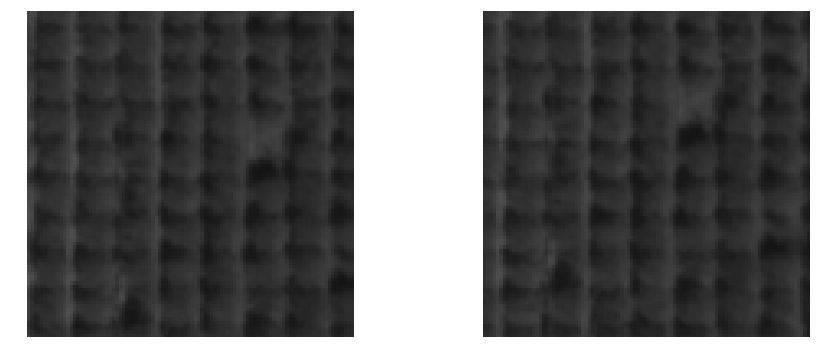

In [146]:
img, img_offset, x_offset, y_offset = get_row(norm_img, size=100, max_offset=20)
imgs = np.array([img, img_offset])
show_imgs(imgs)

In [147]:
def gen_batch(source_img, img_size=80, max_offset=20, batch_size=32):
    while True:
        imgs = []
        imgs_offset=[]
        offsets = []
        for i in range(batch_size):
            results = get_row(source_img,size=img_size, max_offset=max_offset)
            img, img_offset, x_offset, y_offset = results 
            imgs.append(img)
            imgs_offset.append(img_offset)
            offsets.append((x_offset, y_offset))

        X = [np.array(imgs), np.array(imgs_offset)]
        Y = np.array(offsets)

        yield X, Y

In [148]:
gen  = gen_batch(norm_img)
X, Y = next(gen)
print(X[0].shape)
print(X[1].shape)
print(Y.shape)

(32, 80, 80, 3)
(32, 80, 80, 3)
(32, 2)


In [149]:
import keras
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import merge

img = Input(shape=(80, 80,3), name='img')



#create convolution layers
x = Convolution2D(8, (3,3), strides=(1,1), activation='relu')(img)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Convolution2D(16, (3,3), strides=(1,1), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Convolution2D(32, (3,3), strides=(1,1), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Convolution2D(32, (3,3), strides=(1,1), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten(name='flattened')(x)

#create convolution layers

img_offset = Input(shape=(80, 80,3), name='img_offset')

y = Convolution2D(8, (3,3), strides=(1,1), activation='relu')(img_offset)
y = MaxPooling2D(pool_size=(2,2))(y)

y = Convolution2D(16, (3,3), strides=(1,1), activation='relu')(y)
y = MaxPooling2D(pool_size=(2,2))(y)

y = Convolution2D(32, (3,3), strides=(1,1), activation='relu')(y)
y = MaxPooling2D(pool_size=(2,2))(y)

y = Convolution2D(32, (3,3), strides=(1,1), activation='relu')(y)
y = MaxPooling2D(pool_size=(2,2))(y)

y = Flatten(name='flattened_offset')(y)


z = keras.layers.Concatenate(axis=1)([x,y])


#create dense layers
z = Dense(32, activation='relu')(z)
z = Dropout(.2)(z)

#continous output of throttle
offsets = Dense(2, activation='relu', name='offsets')(z)

model = Model(inputs=[img, img_offset], outputs=[offsets])

#define loss function that weights angle loss more than throttle loss
model.compile(optimizer='adam',
              loss={'offsets': 'mean_squared_error'},
              loss_weights={'offsets': 1.0})

In [172]:
img = Input(shape=(80, 80,3), name='img')

#create convolution layers
x = Dense(32, activation='relu')(img)
x = Dropout(.2)(x)

x = Flatten(name='flattened')(x)

#create convolution layers

img_offset = Input(shape=(80, 80,3), name='img_offset')

y = Dense(32, activation='relu')(img_offset)
y = Dropout(.2)(y)

y = Flatten(name='flattened_offset')(y)

z = keras.layers.Concatenate(axis=1)([x,y])

#create dense layers
z = Dense(16, activation='sigmoid')(z)
z = Dropout(.2)(z)

#continous output of throttle
offsets = Dense(2, activation='sigmoid', name='offsets')(z)

model = Model(inputs=[img, img_offset], outputs=[offsets])

#define loss function that weights angle loss more than throttle loss
model.compile(optimizer='adam',
              loss='mean_squared_error')

In [173]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
img (InputLayer)                 (None, 80, 80, 3)     0                                            
____________________________________________________________________________________________________
img_offset (InputLayer)          (None, 80, 80, 3)     0                                            
____________________________________________________________________________________________________
dense_20 (Dense)                 (None, 80, 80, 32)    128                                          
____________________________________________________________________________________________________
dense_21 (Dense)                 (None, 80, 80, 32)    128                                          
___________________________________________________________________________________________

In [180]:
X[1]

array([[[[ 0.27191981,  0.27191981,  0.27191981],
         [ 0.27191981,  0.27191981,  0.27191981],
         [ 0.27976295,  0.27976295,  0.27976295],
         ..., 
         [ 0.22878256,  0.22878256,  0.22878256],
         [ 0.22093942,  0.22093942,  0.22093942],
         [ 0.22093942,  0.22093942,  0.22093942]],

        [[ 0.27191981,  0.27191981,  0.27191981],
         [ 0.26015511,  0.26015511,  0.26015511],
         [ 0.2483904 ,  0.2483904 ,  0.2483904 ],
         ..., 
         [ 0.22486099,  0.22486099,  0.22486099],
         [ 0.21701785,  0.21701785,  0.21701785],
         [ 0.20917472,  0.20917472,  0.20917472]],

        [[ 0.27191981,  0.27191981,  0.27191981],
         [ 0.26799825,  0.26799825,  0.26799825],
         [ 0.2366257 ,  0.2366257 ,  0.2366257 ],
         ..., 
         [ 0.22093942,  0.22093942,  0.22093942],
         [ 0.20917472,  0.20917472,  0.20917472],
         [ 0.19741001,  0.19741001,  0.19741001]],

        ..., 
        [[ 0.27976295,  0.27976295,

In [175]:
model.fit_generator(generator=gen, steps_per_epoch=50, epochs=2)

Epoch 1/2
50/50 [==============================] - 42s - loss: 0.0983    
Epoch 2/2
50/50 [==============================] - 59s - loss: 0.0674    


In [176]:
model.fit_generator(generator=gen, steps_per_epoch=100, epochs=2)

Epoch 1/2
 24/100 [======>.......................] - ETA: 105s - loss: 0.0575

KeyboardInterrupt: 

In [177]:
X, Y = next(gen)

In [178]:
Y

array([[ 0.0125,  0.1125],
       [ 0.075 ,  0.1125],
       [-0.1375, -0.0375],
       [-0.25  , -0.1375],
       [-0.2375, -0.1625],
       [ 0.0125, -0.225 ],
       [ 0.    ,  0.1125],
       [ 0.075 ,  0.025 ],
       [ 0.15  , -0.05  ],
       [ 0.15  , -0.2375],
       [-0.0875, -0.1125],
       [-0.1625, -0.1375],
       [ 0.1625,  0.225 ],
       [ 0.    ,  0.0875],
       [ 0.0875,  0.0625],
       [-0.125 , -0.0625],
       [-0.0125,  0.05  ],
       [ 0.0875, -0.15  ],
       [ 0.2125, -0.1875],
       [ 0.0875, -0.225 ],
       [ 0.2   , -0.2125],
       [-0.125 , -0.2   ],
       [-0.1875,  0.1125],
       [ 0.175 ,  0.125 ],
       [ 0.    ,  0.2125],
       [-0.25  , -0.075 ],
       [ 0.175 , -0.2125],
       [ 0.1875,  0.2   ],
       [-0.15  ,  0.05  ],
       [ 0.1625, -0.175 ],
       [-0.1625,  0.0875],
       [-0.225 , -0.1125]])

In [179]:
model.predict(X)

array([[ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,  0.10830577],
       [ 0.2004346 ,

In [181]:
arange(1,10)

NameError: name 'arange' is not defined